In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install duka
!pip install mplfinance

  Created wheel for duka: filename=duka-0.2.0-py3-none-any.whl size=10718 sha256=f28a36fd9fb76969bf3315af47fde791202c85f2e9b4d4549e25444da569a47b
  Stored in directory: /root/.cache/pip/wheels/71/71/d7/5520ded9506fb8be12fb4e4e64cbafe564adb00cf228e7e849
Successfully built duka
     |████████████████████████████████| 70 kB 3.7 MB/s 


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf

from duka.core.utils import TimeFrame
import duka.app.app as import_data

import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta

from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

In [5]:
path = 'drive/MyDrive/Colab Notebooks/Trading/data/'

In [35]:
now = datetime.datetime.now()


start_date = now + relativedelta(months=-4)
start_date = datetime.date(int(start_date.strftime("%Y")), 
                           int(start_date.strftime("%m")), 
                           int(start_date.strftime("%d")))

end_date = datetime.date(int(now.strftime("%Y")), 
                         int(now.strftime("%m")), 
                         int(now.strftime("%d")))

print(f"Start Date {start_date}")
print(f"End Date {end_date}")

# import_data(["EURUSD"], start_date, end_date, 1, TimeFrame.D1, path, True)
candles = pd.read_csv(path + 'EURUSD-' + start_date.strftime('%Y_%m_%d') + '-' + \
                                         end_date.strftime('%Y_%m_%d') + '.csv')  

candles.reset_index(inplace=True)
candles.head()

Start Date 2021-12-28
End Date 2022-04-28


,index,time,open,close,high,low
0,0,2021-12-28 00:00:00,1.13297,1.13134,1.13336,1.12898
1,1,2021-12-29 00:00:00,1.13132,1.13599,1.13691,1.12739
2,2,2021-12-30 00:00:00,1.13600,1.13227,1.13601,1.12986
3,3,2021-12-31 00:00:00,1.13222,1.13751,1.13867,1.13035
4,4,2022-01-02 00:00:00,1.13776,1.13731,1.13802,1.13690


In [36]:
candles['date'] = pd.to_datetime(candles['time']).dt.tz_localize("Etc/UTC")
candles.set_index('date', inplace=True)

del candles['time']
del candles['index']

candles.head()

,open,close,high,low
date,,,,
2021-12-28 00:00:00+00:00,1.13297,1.13134,1.13336,1.12898
2021-12-29 00:00:00+00:00,1.13132,1.13599,1.13691,1.12739
2021-12-30 00:00:00+00:00,1.13600,1.13227,1.13601,1.12986
2021-12-31 00:00:00+00:00,1.13222,1.13751,1.13867,1.13035
2022-01-02 00:00:00+00:00,1.13776,1.13731,1.13802,1.13690


In [37]:
# definire classe per inserimento dati aggiuntivi
class Technical_Analysis:
  def __init__(self, candles):
    self.candles = candles
    self.bollinger()
    self.ichimoku()
    self.donchian()
    self.momentum()

  def bollinger(self):
    mean = self.candles['close']
    mean = mean.rolling(window=10).mean()
    std_dev = self.candles['close']
    std_dev = std_dev.rolling(window=10).std()
    self.candles['UpperBB'] = mean + (2 * std_dev)
    self.candles['LowerBB'] = mean - (2 * std_dev)


  def ichimoku(self):
    period9_high = self.candles['high'].rolling(window=9).max()
    period9_low = self.candles['low'].rolling(window=9).min()
    self.candles['tenkan_sen'] = (period9_high + period9_low) / 2

    # Kijun-sen (Base Line): (26-period high + 26-period low)/2))
    period26_high = self.candles['high'].rolling(window=26).max()
    period26_low = self.candles['low'].rolling(window=26).min()
    self.candles['kijun_sen'] = (period26_high + period26_low) / 2

    # Senkou Span A (Leading Span A): (Conversion Line + Base Line)/2))
    self.candles['senkou_span_a'] = ((self.candles['tenkan_sen'] + self.candles['kijun_sen']) / 2).shift(26)

    # Senkou Span B (Leading Span B): (52-period high + 52-period low)/2))
    period52_high = self.candles['high'].rolling(window=52).max()
    period52_low = self.candles['low'].rolling(window=52).min()
    self.candles['senkou_span_b'] = ((period52_high + period52_low) / 2).shift(26)

  def donchian(self):
    #Calcolo canali Donchian. Questa tecnica ha 3 linee, ma proviamo ad inserire nel dataset solo la centrale
    self.candles['don_high'] = self.candles['high'].rolling(window=20).max()
    self.candles['don_low'] = self.candles['low'].rolling(window=20).min()

    #semplice media tra il minimo e il massimo in un dato tempo (20 qui)
    self.candles['don_mean'] = (self.candles['don_high'] + self.candles['don_low']) / 2 

  def momentum(self):
    self.candles['momentum'] = (self.candles['close'] / self.candles['close'].shift(14))


Technical_Analysis(candles=candles)
candles.head(-10)

,open,close,high,low,UpperBB,LowerBB,tenkan_sen,kijun_sen,senkou_span_a,senkou_span_b,don_high,don_low,don_mean,momentum
date,,,,,,,,,,,,,,
2021-12-28 00:00:00+00:00,1.13297,1.13134,1.13336,1.12898,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-29 00:00:00+00:00,1.13132,1.13599,1.13691,1.12739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-30 00:00:00+00:00,1.13600,1.13227,1.13601,1.12986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-31 00:00:00+00:00,1.13222,1.13751,1.13867,1.13035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-02 00:00:00+00:00,1.13776,1.13731,1.13802,1.13690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-11 00:00:00+00:00,1.08844,1.08772,1.09334,1.08730,1.111010,1.078022,1.095625,1.101090,1.106298,1.11507,1.11852,1.08366,1.101090,0.990259
2022-04-12 00:00:00+00:00,1.08773,1.08262,1.09038,1.08214,1.107381,1.076713,1.093810,1.100330,1.103805,1.11507,1.11852,1.08214,1.100330,0.985831
2022-04-13 00:00:00+00:00,1.08262,1.08954,1.08975,1.08091,1.102927,1.078097,1.093195,1.099715,1.103252,1.11507,1.11852,1.08091,1.099715,0.991257


## Grafici

Limiti temporali del dataset scaricato

In [16]:
print(candles.iloc[0].name, '-', candles.iloc[-1].name)

2021-04-27 00:00:00+00:00 - 2022-04-26 00:00:00+00:00


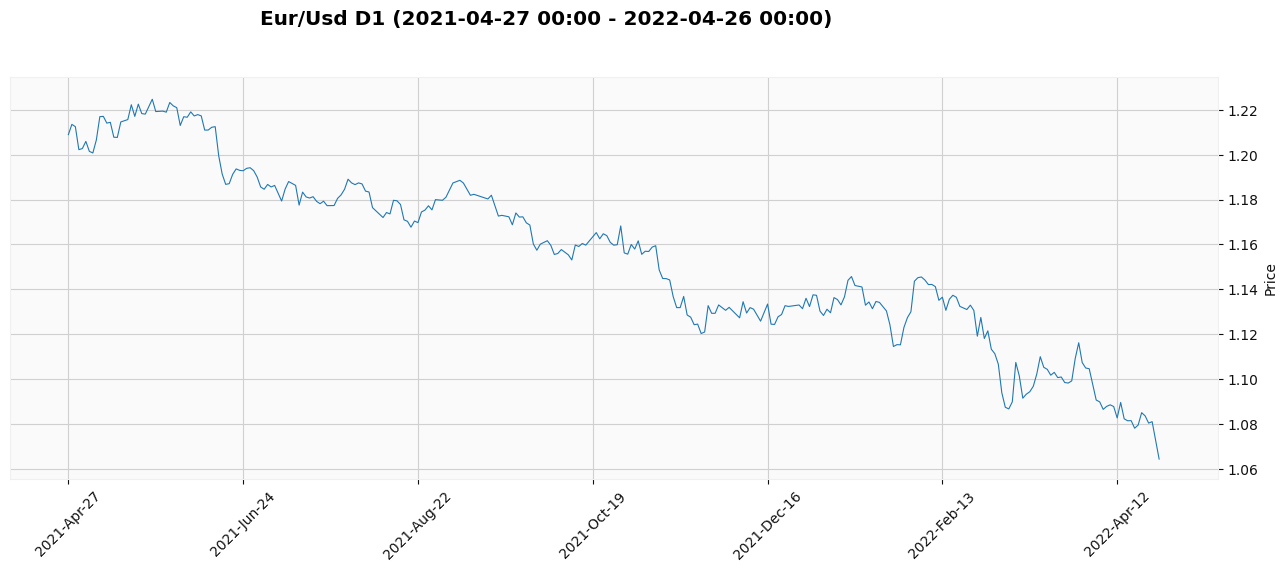

In [17]:
title = 'Eur/Usd D1 (' + str(candles.iloc[0].name)[:16] + ' - ' + str(candles.iloc[-1].name)[:16]+')'

mpf.plot(
    candles, 
    type='line', 
    figratio=(35,12), 
    style='yahoo', 
    title=title
)

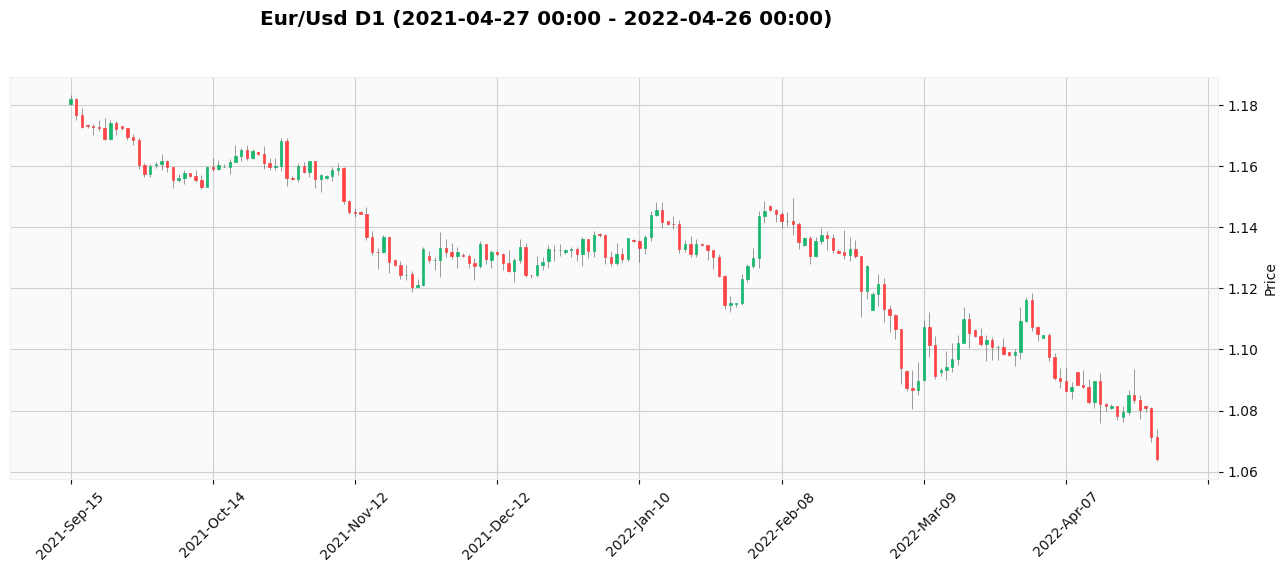

In [18]:
title = 'Eur/Usd D1 (' + str(candles.iloc[0].name)[:16] + ' - ' + str(candles.iloc[-1].name)[:16]+')'

mpf.plot(
    candles.iloc[-192:], 
    type='candle', 
    figratio=(35,12), 
    style='yahoo', 
    title=title
)

## Medie Mobili

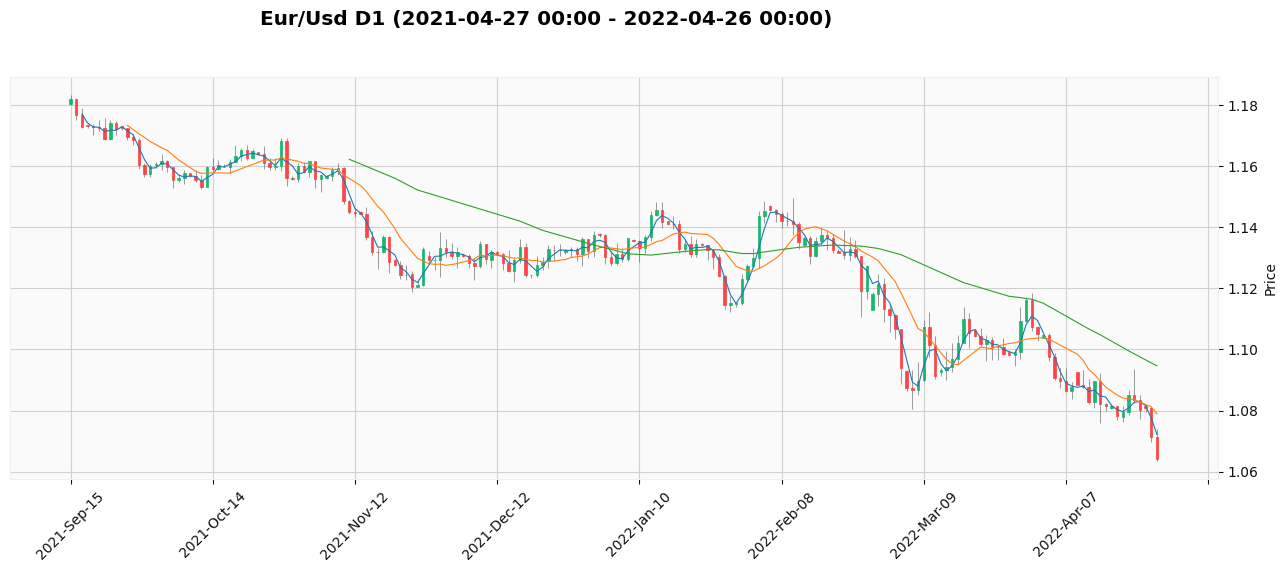

In [19]:
mpf.plot(
    candles.iloc[-192:],
    mav=(3, 11, 50), 
    type='candle', 
    figratio=(35,12), 
    style='yahoo', 
    title=title
)

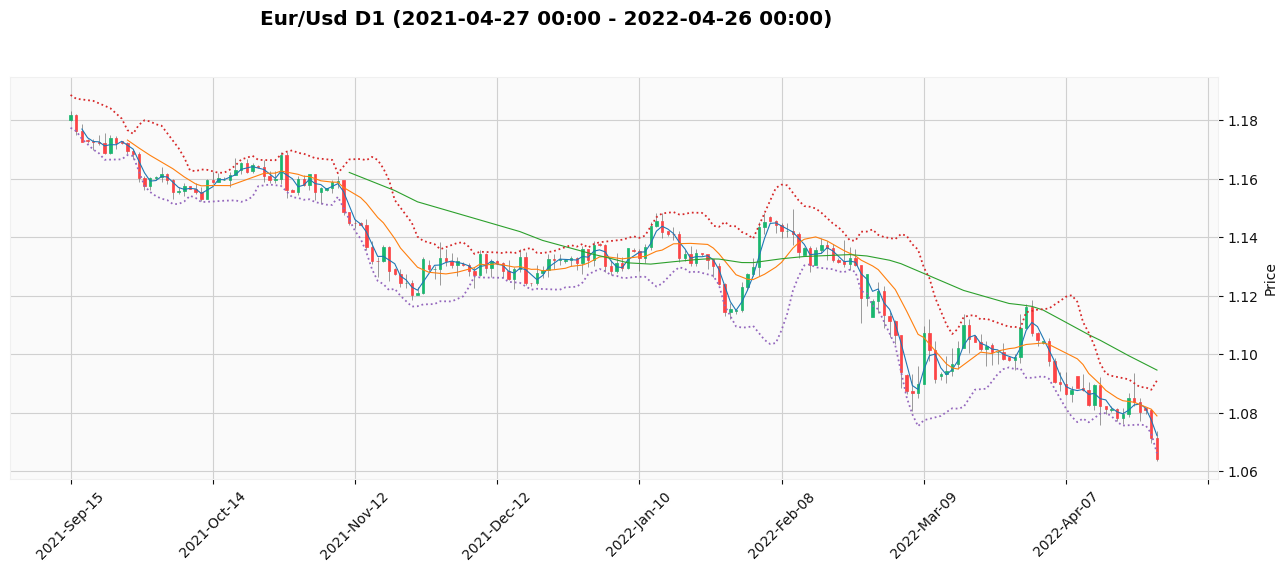

In [20]:
bollinger_bands = candles[['UpperBB', 'LowerBB']]

bollinger_bands_plot = mpf.make_addplot(bollinger_bands[-192:], linestyle='dotted')
mpf.plot(
    candles.iloc[-192:], 
    type='candle',
    mav=(3, 11, 50),
    figratio=(35,12), 
    style='yahoo', 
    addplot=bollinger_bands_plot, 
    title=title
)

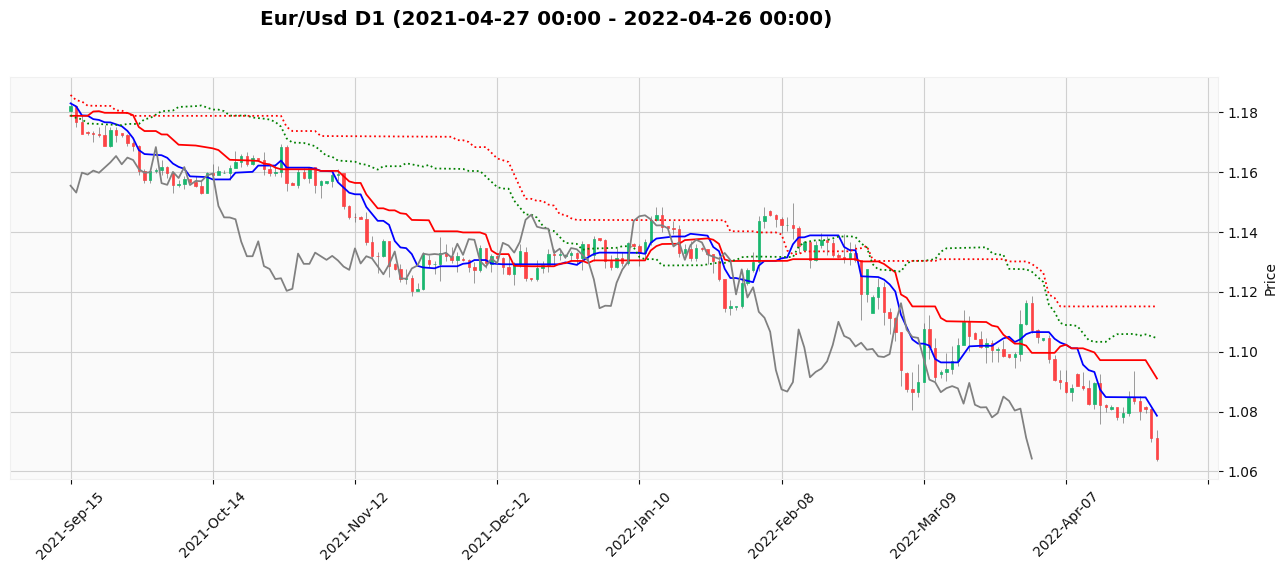

In [21]:
# The most current closing price plotted 22 time periods behind (optional)
chikou_span = candles['close'].shift(-22) # 22 according to investopedia

ichimoku = candles[['tenkan_sen', 'kijun_sen', 'senkou_span_a', 'senkou_span_b']]

# candles_plot = mpf.make_addplot(candles['close'][-192:], panel=1, type='line', color='black')
add_plots= [mpf.make_addplot(ichimoku['tenkan_sen'][-192:], color='blue'),
            mpf.make_addplot(ichimoku['kijun_sen'][-192:], color='red'),
            mpf.make_addplot(ichimoku['senkou_span_a'][-192:], linestyle='dotted', color='green'),
            mpf.make_addplot(ichimoku['senkou_span_b'][-192:], linestyle='dotted', color='red'),
            mpf.make_addplot(chikou_span[-192:], color='gray')
           ]

mpf.plot(
    candles.iloc[-192:], 
    type='candle',
    figratio=(35,12), 
    style='yahoo', 
    addplot=add_plots, 
    title=title
)

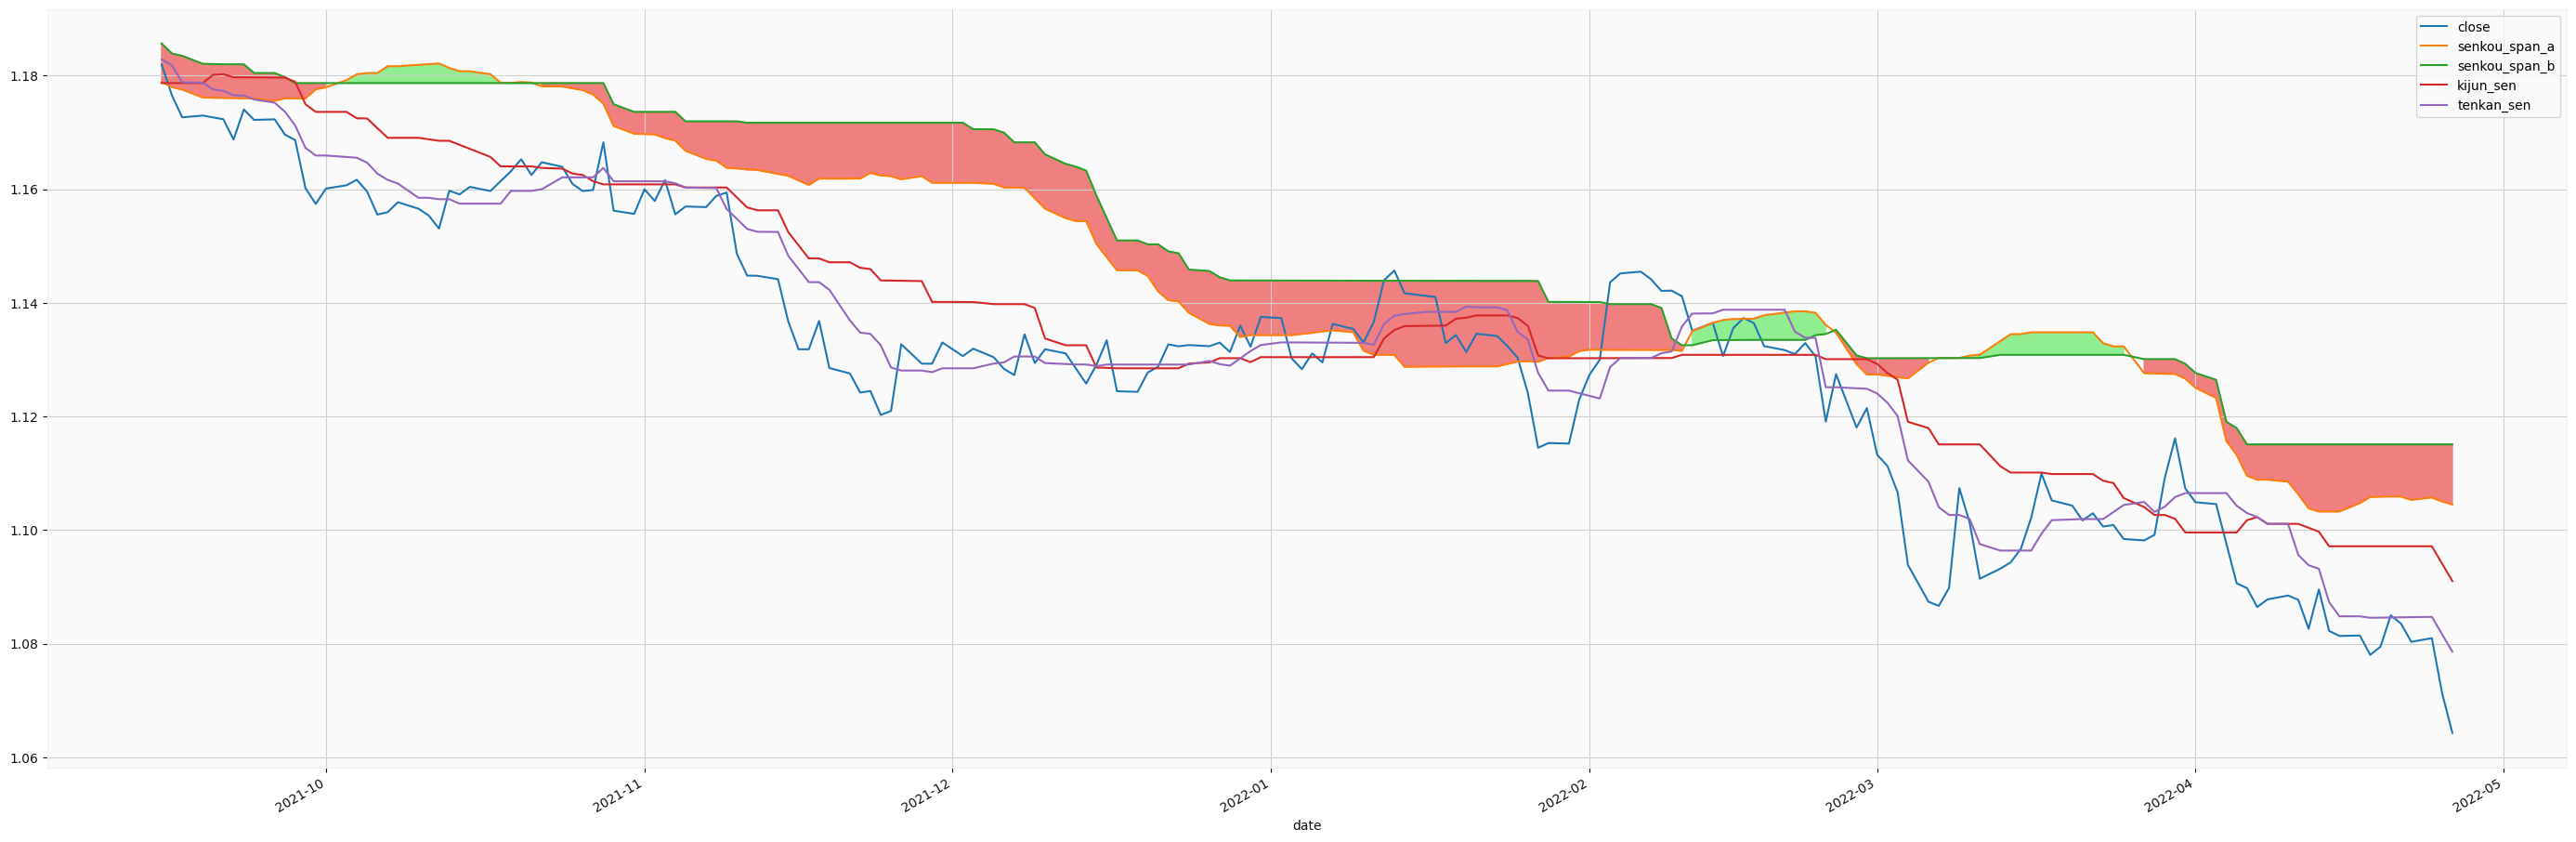

In [22]:
ichimoku = candles[['close', 'senkou_span_a', 'senkou_span_b', 'kijun_sen', 'tenkan_sen']].tail(192)
plot = ichimoku.plot(figsize=(35,12))
plt.fill_between(ichimoku.index, 
                 ichimoku.senkou_span_a, 
                 ichimoku.senkou_span_b,
                 where=ichimoku.senkou_span_a >= ichimoku.senkou_span_b, 
                 color='lightgreen')

plt.fill_between(ichimoku.index, 
                 ichimoku.senkou_span_a, 
                 ichimoku.senkou_span_b,
                 where=ichimoku.senkou_span_a < ichimoku.senkou_span_b, 
                 color='lightcoral')


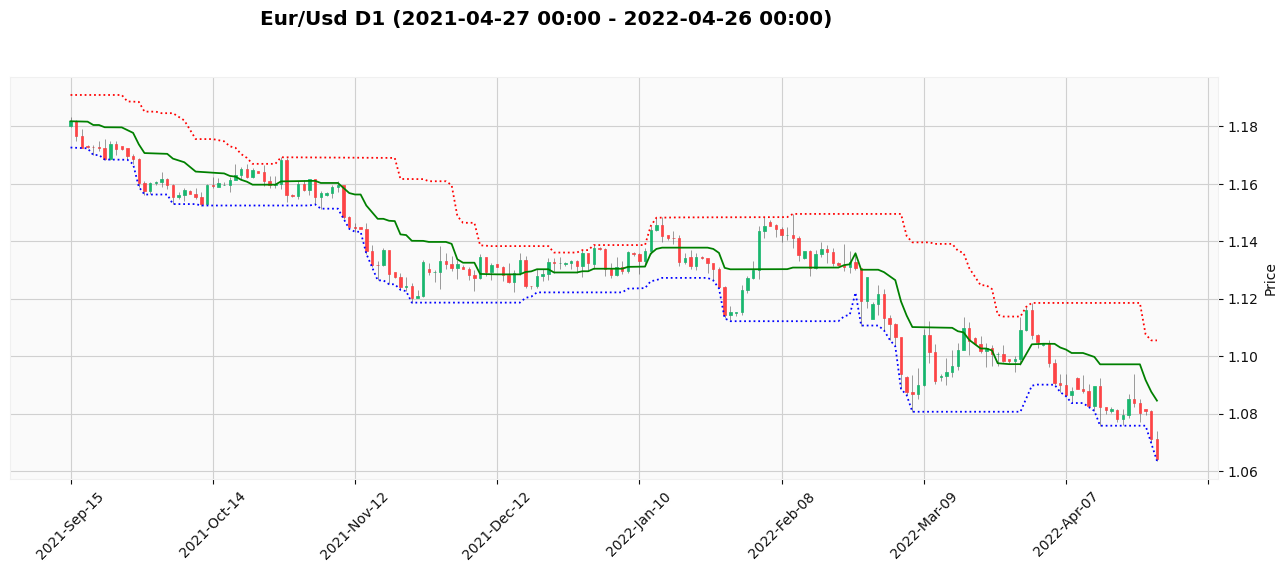

In [23]:
don_sup_plot = mpf.make_addplot(candles['don_high'][-192:], linestyle='dotted', color='red')
don_inf_plot = mpf.make_addplot(candles['don_low'][-192:], linestyle='dotted', color='blue')
don_cen_plot = mpf.make_addplot(candles['don_mean'][-192:], color='green')

mpf.plot(
    candles.iloc[-192:],
    type='candle',
    figratio=(35,12),
    style='yahoo',
    addplot=[don_sup_plot, don_inf_plot, don_cen_plot],
    title=title
)

## Momentum

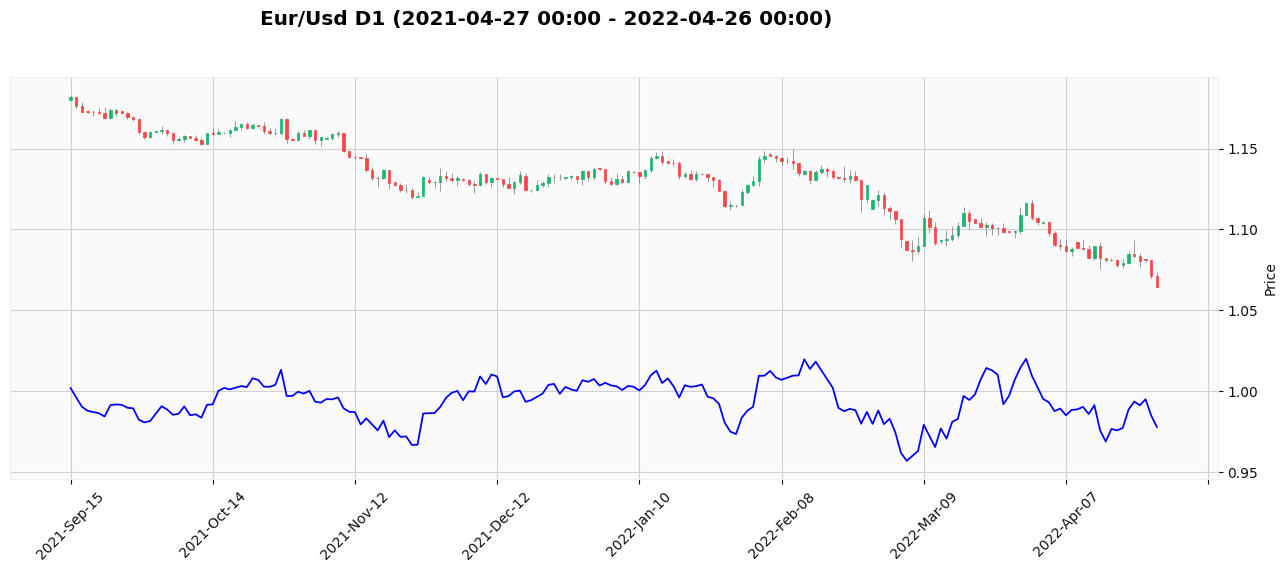

In [24]:
momentum_plot = mpf.make_addplot(candles['momentum'][-192:], color='blue')

mpf.plot(
    candles.iloc[-192:],
    type='candle',
    figratio=(35,12),
    style='yahoo',
    addplot=[momentum_plot],
    title=title
)

In [25]:
print(candles.iloc[0].name, '-', candles.iloc[-1].name)

2021-04-27 00:00:00+00:00 - 2022-04-26 00:00:00+00:00


## Serie Temporali

In [39]:
scaler = MinMaxScaler(feature_range=(0.2, 0.8))
candles_norm = scaler.fit_transform(candles)

# candles_norm = np.asarray(candles, dtype=np.float32)
# candles_norm = candles_norm[-193:]
candles_date = candles
candles_norm = candles_norm[78:]

print(candles.iloc[-97])
print('----------------------')
print(candles_norm[-97])
print('----------------------')
print(candles.iloc[-97].name)
print(candles_date.iloc[1+95].name)
print(candles_date.iloc[1+191].name)
print(candles_date.iloc[-1].name)
print('----------------------')
print(len(candles_norm[:,1]))
print(len(candles))

open             1.130230
close            1.128320
high             1.132260
low              1.127240
UpperBB          1.139097
LowerBB          1.127079
tenkan_sen       1.132955
kijun_sen        1.130430
senkou_span_a    1.134530
senkou_span_b    1.143935
don_high         1.138670
don_low          1.122190
don_mean         1.130430
momentum         1.003558
Name: 2022-01-04 00:00:00+00:00, dtype: float64
----------------------
[0.43047445 0.43946893 0.42922231 0.44246575 0.41626528 0.44322819
 0.42901776 0.38626231 0.36509633 0.39109566 0.36433405 0.4396324
 0.40559534 0.64408312]
----------------------
2022-01-04 00:00:00+00:00
2021-08-17 00:00:00+00:00
2021-12-07 00:00:00+00:00
2022-04-26 00:00:00+00:00
----------------------
235
313


In [29]:
x_candles = []
x_time = []


step_back = 7 # 7 candele D1 compongono una settimana

for i in range(len(candles_norm) - step_back):
    x_candles.append(candles_norm[i:i + step_back])

    t = candles.iloc[78 + i + step_back -1].name # 78 per la rimozione dei valori NaN derivati dal calcolo delle Bollinger Bands e nuvole Ichimoku
    x_time.append([t.weekday() / 7])

In [30]:
print(len(x_candles))
print(len(x_time))
print(x_candles[0])
print(x_time[0])
print('-----------------')
# print(x_candles[1])
# print(x_time[1])
# print(x_candles[-1])
# print(x_time[1])

228
228
[[0.6270464  0.64049118 0.63291438 0.63184932 0.60086153 0.63750821
  0.62578811 0.64341867 0.70485616 0.8        0.61615778 0.65618788
  0.63809311 0.56862063]
 [0.63318561 0.64991585 0.63625295 0.63280061 0.60801008 0.63387742
  0.62757846 0.63992123 0.70075218 0.8        0.61615778 0.65618788
  0.63809311 0.59647564]
 [0.64300052 0.66663342 0.65392773 0.65882801 0.62317781 0.62575278
  0.6370568  0.63502954 0.70081816 0.8        0.6158607  0.65618788
  0.63795882 0.70343158]
 [0.66047967 0.66053731 0.65946583 0.6629376  0.63122208 0.62471444
  0.64002668 0.63493501 0.70017155 0.79927176 0.62284205 0.65618788
  0.64111459 0.64336109]
 [0.65332377 0.65762015 0.64544383 0.66700913 0.63602103 0.62695997
  0.64059538 0.63493501 0.69445764 0.79672294 0.62284205 0.65618788
  0.64111459 0.65436752]
 [0.65109489 0.66049991 0.65487038 0.66575342 0.64076867 0.6289827
  0.64059538 0.63493501 0.68544471 0.78682555 0.62284205 0.65618788
  0.64111459 0.66461259]
 [0.65414494 0.65877953 0.6

In [31]:
model = keras.models.load_model(path + 'Model_500_epochs_48_batch_filters_8_16_32_momentum_8.h5')

x_candles = np.asarray(x_candles, dtype=np.float32)
x_time = np.asarray(x_time, dtype=np.float32)

preds = model.predict([x_candles, x_time], batch_size=256)


In [34]:
print(len(preds))
print(len(preds[0]))
print(len(preds[0][0]))
print('--------------------')
print('Feature Close')
# print(preds[0]) # Features Close
print('\n')
print('Sequnza di 4 istanti temporali')
print(preds[0][0]) # Sequenza di 4 istanti temporali
print(preds[0][1]) # Sequenza di 4 istanti temporali
print('\n')
print('Primo valore della sequenza')
print(preds[0][0]) # Primo valore della sequenza

3
228
1
--------------------
Feature Close


Sequnza di 4 istanti temporali
[0.6721437]
[0.66370785]


Primo valore della sequenza
[0.6721437]


In [35]:
preds_close = preds[0]
preds_high = preds[1]
preds_low = preds[2]

In [47]:
close_list0 = [item[0] for item in preds_close]
print(close_list0)

[0.93216026, 0.9329201]


In [39]:
print(type(preds_close[0]))

<class 'numpy.ndarray'>


In [43]:
lista_valori = [preds_close[0][0], preds_close[1][0]]
a = np.asarray(lista_valori, dtype=np.float32)

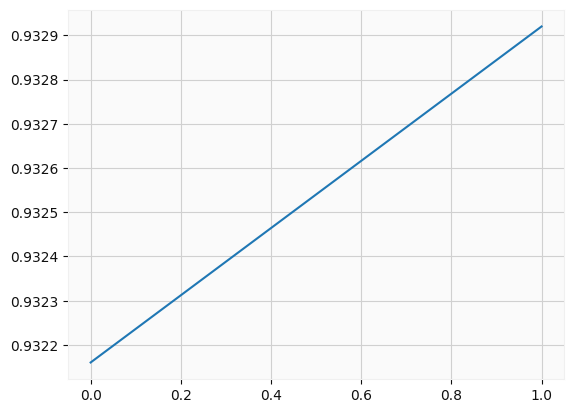

In [44]:
#plt.plot(preds_close[0], label='preds1')
#plt.plot(preds_close[1], label='preds2')
plt.plot(lista_valori, label='lista valori')
plt.show()

In [36]:
def denorm(value):
    example = [0.5 for x in range(14)]
    example[1] = value
    return scaler.inverse_transform([example])[0][1]


In [ ]:
pips_total = 0
total_pips_history = []
single_pips_history = []

for i in range(len(preds)):
    prediction = preds[i]
    print(prediction)
    predicted_close = denorm(prediction)
    previous_close = denorm(candles_norm[i-1][1])
    actual_close = denorm(candles_norm[i][1])
    real_next_close = denorm(candles_norm[i+1][3])

#    if previous_close < predicted_close:  # buy
#        profit = real_next_close - actual_close
#        pips_total += profit
#        total_pips_history.append(pips_total)
#        single_pips_history.append(profit)
#        
#    if previous_close > predicted_close:  # sell
#        profit = actual_close - real_next_close
#        pips_total += profit
#        total_pips_history.append(pips_total)
#        single_pips_history.append(profit)

In [ ]:
print('Total earned', pips_total)

plt.subplot(1, 2, 1)
plt.plot(total_pips_history)
plt.title('Cumulative earned history')

plt.subplot(1, 2, 2)
plt.plot(single_pips_history)
plt.title('Single movement earned history')

plt.tight_layout()
plt.show()

In [ ]:
title = 'Eur/Usd D1 (' + str(candles_date.iloc[0].name)[:16] + ' - ' + str(candles_date.iloc[-1].name)[:16]+')'

prediction = mpf.make_addplot(preds_close[0:], color='blue', ylabel='Prediction')
print(candles_date.shape)
print(len(preds_close))
print(len(candles_date))
mpf.plot(
    candles_date[0:], 
    type='candle', 
    figratio=(35,12), 
    style='yahoo',
    addplot=[prediction], 
    title=title
)

In [ ]:
plt.figure(figsize=(50,30))
candles_close = candles_date['close']

plt.scatter(range(192), preds_close[-192:], label='close pred')
plt.scatter(range(191), candles_close[-192:-1], alpha=1, label='real close')
plt.legend(fontsize=30)

plt.show()

## Prediction

In [38]:
candles.head()

,open,close,high,low,UpperBB,LowerBB,tenkan_sen,kijun_sen,senkou_span_a,senkou_span_b,don_high,don_low,don_mean,momentum
date,,,,,,,,,,,,,,
2021-12-28 00:00:00+00:00,1.13297,1.13134,1.13336,1.12898,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-29 00:00:00+00:00,1.13132,1.13599,1.13691,1.12739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-30 00:00:00+00:00,1.13600,1.13227,1.13601,1.12986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-31 00:00:00+00:00,1.13222,1.13751,1.13867,1.13035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-02 00:00:00+00:00,1.13776,1.13731,1.13802,1.13690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
model = keras.models.load_model(path + 'Model_500_epochs_48_batch_filters_8_16_32_momentum_8.h5')

In [40]:
scaler = MinMaxScaler(feature_range=(0.2, 0.8))

In [41]:
def denorm(value, num_features):
  example = np.array([0.5 for x in range(14)], dtype=object)
  example[num_features] = value
  return scaler.inverse_transform([example])[0][num_features]

In [42]:
def min_max_scaler(candles):
  candles_norm = scaler.fit_transform(candles)
  candles_norm = candles_norm[78:]
  return candles_norm

In [43]:
def time_series(candles):
  x_candles = []
  x_time = []

  step_back = 7 # 7 candele D1 compongono una settimana

  candles_norm = min_max_scaler(candles)

  for i in range(len(candles_norm) - step_back):
      x_candles.append(candles_norm[i:i + step_back])

      t = candles.iloc[78 + i + step_back -1].name # 78 per la rimozione dei valori NaN derivati dal calcolo delle Bollinger Bands e nuvole Ichimoku
      x_time.append([t.weekday() / 7])
  
  return x_candles, x_time

In [44]:
def prediction(candles):
  x_candles, x_time = time_series(candles)

  x_candles = np.asarray(x_candles, dtype=np.float32)
  x_time = np.asarray(x_time, dtype=np.float32)

  preds = model.predict([x_candles, x_time], batch_size=256)

  return preds

In [46]:
num_preds = 7

for i in range(num_preds):
  preds = prediction(candles)

  preds_close = preds[0]
  preds_high = preds[1]
  preds_low = preds[2]

  preds_open = denorm(preds_close[-2], 1)
  preds_close = denorm(preds_close[-1], 1)
  preds_high = denorm(preds_high[-1], 2)
  preds_low = denorm(preds_low[-1], 2)

  # print(preds_open)
  # print(type(preds_open))
  # preds_close = np.reshape(preds_close[-1], -1)
  # preds_high = np.reshape(preds_high, -1)
  # preds_low = np.reshape(preds_low, -1)
  candles.reset_index(inplace=True)

  last_date = candles['date'].iloc[-1]
  new_date = last_date + timedelta(days=1)
  
  candles = candles.append({'date' : new_date,
                            'open' : preds_open,
                            'close' : preds_close, 
                            'high' : preds_high, 
                            'low' : preds_low},
                            ignore_index=True)
  
  candles.set_index('date', inplace=True)

  Technical_Analysis(candles)

candles.tail(-4)

,open,close,high,low,UpperBB,LowerBB,tenkan_sen,kijun_sen,senkou_span_a,senkou_span_b,don_high,don_low,don_mean,momentum
date,,,,,,,,,,,,,,
2022-01-02 00:00:00+00:00,1.137760,1.137310,1.138020,1.136900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-03 00:00:00+00:00,1.137320,1.130230,1.137590,1.128000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-04 00:00:00+00:00,1.130230,1.128320,1.132260,1.127240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-05 00:00:00+00:00,1.128300,1.131090,1.134660,1.127730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-06 00:00:00+00:00,1.131100,1.129510,1.133210,1.128480,NaN,NaN,1.132955,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-07 00:00:00+00:00,1.055427,1.054776,1.069947,1.069760,1.057086,1.048845,1.065091,1.07257,1.101090,1.115070,1.09366,1.05148,1.07257,0.976355
2022-05-08 00:00:00+00:00,1.054869,1.054654,1.069484,1.069463,1.056243,1.049292,1.066926,1.07257,1.101090,1.115070,1.09366,1.05148,1.07257,0.975655
2022-05-09 00:00:00+00:00,1.054757,1.054829,1.069534,1.068054,1.056702,1.049413,1.067927,1.07257,1.098358,1.115070,1.09366,1.05148,1.07257,0.984644
